In [1]:
import pandas as pd
import numpy as np

import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
current_folder = os.getcwd()
 
dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [9]:
dataset_path = os.path.dirname(dataset)
dataset_dir = os.path.join(dataset_path, 'aclImdb')
train_dir = os.path.join(dataset_dir,'train')


In [10]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        #print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
             
    return pd.DataFrame.from_dict(data)

In [11]:
train_df = load_dataset(train_dir)
train_df

sentence  sentiment
0      Working with one of the best Shakespeare sourc...          0
1      Well...tremors I, the original started off in ...          0
2      Ouch! This one was a bit painful to sit throug...          0
3      I've seen some crappy movies in my life, but t...          0
4      "Carriers" follows the exploits of two guys an...          0
...                                                  ...        ...
24995  About a year ago I finally gave up on American...          1
24996  When I saw the elaborate DVD box for this and ...          1
24997  Last November, I had a chance to see this film...          1
24998  Great movie -I loved it. Great editing and use...          1
24999  Enchanted April is a tone poem, an impressioni...          1

[25000 rows x 2 columns]

In [12]:
num = 12499
print(train_df.iloc[num,1])
train_df.iloc[num,0]

0


'Not that I dislike childrens movies, but this was a tearjerker with few redeeming qualities. M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted. Hugh Laurie can be amazingly funny, but is not given the chance in this movie. It´s sugar-coated sugar and would hardly appeal to anyone over 7 years of age. See Toy Story, Monsters Inc. or Shrek instead. 3/10'

In [13]:
test_dir = os.path.join(dataset_dir,'test')
test_df = load_dataset(test_dir)
test_df

sentence  sentiment
0      Alan Rickman & Emma Thompson give good perform...          0
1      I have seen this movie and I did not care for ...          0
2      In Los Angeles, the alcoholic and lazy Hank Ch...          0
3      This film is bundled along with "Gli fumavano ...          0
4      I only comment on really very good films and o...          0
...                                                  ...        ...
24995  This movie is certainly well-constructed, begi...          1
24996  Nice to see a comedy for grown ups. Masterfull...          1
24997  Jean Renoir's homage to the Paris of the late ...          1
24998  What are the movies? I mean.. what are movies ...          1
24999  I saw this movie on TV and loved it! I am a re...          1

[25000 rows x 2 columns]

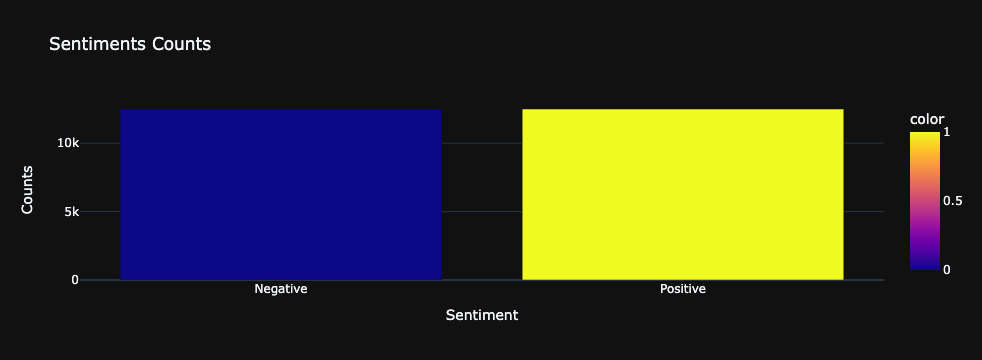

In [14]:
sentiment_counts = train_df['sentiment'].value_counts()
 
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')
 
fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')
 
# Show the bar chart
fig.show()
#pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

In [15]:
   def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [16]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

/var/folders/td/dtym05z13119cjklqb5tyd040000gn/T/ipykernel_20353/3070375720.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/td/dtym05z13119cjklqb5tyd040000gn/T/ipykernel_20353/3070375720.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [17]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

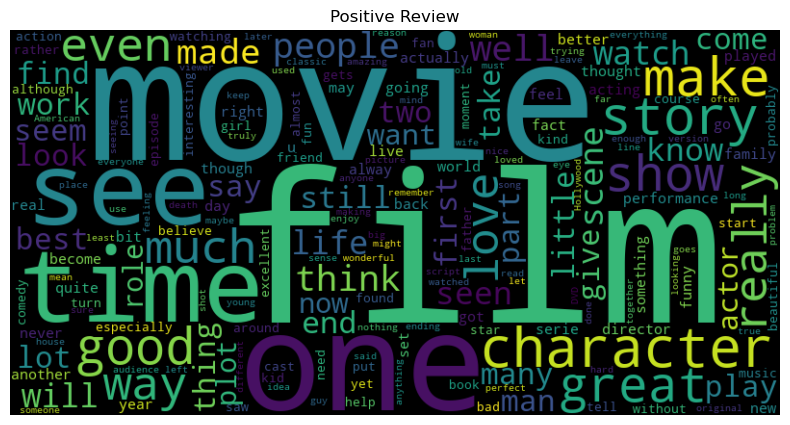

In [18]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

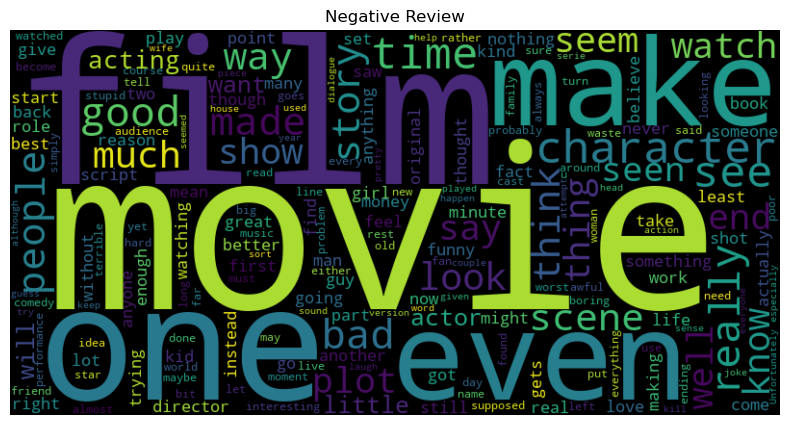

In [19]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')


In [20]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']
 
# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [21]:
 x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [24]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3
  8/782 [..............................] - ETA: 8:53:01 - loss: 0.6909 - accuracy: 0.5352

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x1611ea160>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

In [ ]:
path = os.path.join(os.getcwd(), 'geeksforgeeks_example')
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')
 
# Save model
model.save_pretrained(path +'/Model')

In [ ]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')
 
# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

In [ ]:
pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
 
# pred is of type TFSequenceClassifierOutput
logits = pred.logits
 
# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)
 
# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()
 
label = {
    1: 'positive',
    0: 'Negative'
}
 
# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]
 
print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


In [ ]:
   
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]
 
    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])
 
    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)
 
    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [ ]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015. 
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love. 
The movie has received rave reviews from critics and audiences alike for its stunning visuals, 
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)